Going to do the same as salmon_lin notebook,
but it seems like the linear fit is poor, so lets try quadratic:

In [2]:
import os
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

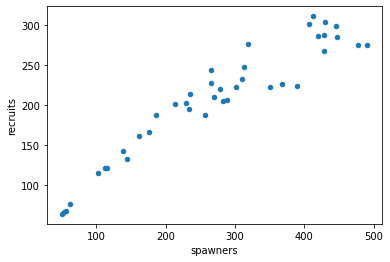

In [3]:
data = pd.read_table('../data/salmon.txt', sep='\s+')
data.plot.scatter(x='spawners', y='recruits');

Simple quadratic regression:

$$ y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \epsilon_i $$

$$ \epsilon_i \sim N(0, \sigma) $$

There are four unknowns, each of which need to be given a prior:

$$\beta_0, \beta_1, \beta_2 \sim \text{Normal}(0, 50)$$

$$\sigma \sim \text{HalfNormal}(50)$$

In [4]:
x, y = data[['spawners', 'recruits']].values.T


In [5]:
with pm.Model() as quad_salmon_model:
    beta = pm.Normal('β', mu=0, sigma=50, shape=3)
    sigma = pm.HalfNormal('σ', sigma=50)
    mu = beta[0] + (beta[1] * x) + (beta[2] * x * x)
    recruits = pm.Normal('recruits', mu=mu, sigma=sigma, observed=y)

In [8]:
with quad_salmon_model:
    quad_trace = pm.sample(1000, tune=2000, cores=4, random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 38 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


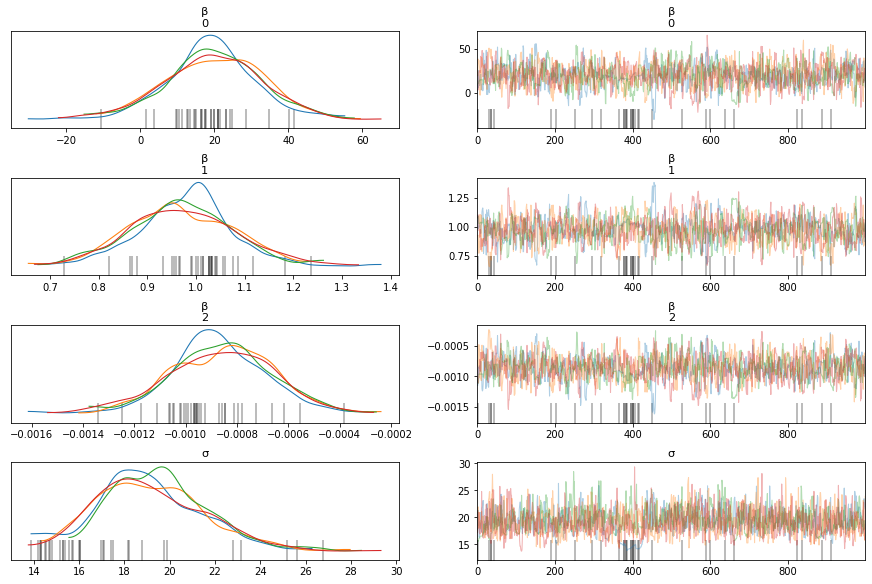

In [9]:
az.plot_trace(quad_trace);

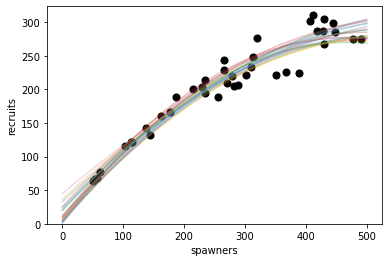

In [11]:
X_pred = np.linspace(0, 500, 100)

ax = data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for b0,b1,b2 in quad_trace['β'][:20]:
    ax.plot(X_pred, b0 + (b1 * X_pred) + (b2 * X_pred * X_pred), alpha=0.3);